In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import skimage.io
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import VGG16, VGG19, resnet50
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2

In [7]:
# train_dir = "../input/fer2013/train"
train_dir = "C:/Users/adity/Downloads/manas_sir_projects/project_paper_coding work/image Data/train"

In [8]:
# test_dir = "../input/fer2013/test"
test_dir = "C:/Users/adity/Downloads/manas_sir_projects/project_paper_coding work/image Data/test"

In [9]:
def img_count(path, sets):
    dic = {}
    for i in os.listdir(path):
        dirs = path+"/"+i
        dic[i] = len(os.listdir(dirs))
    df = pd.DataFrame(dic, index = [sets])
    return df

In [10]:
train_count = img_count(train_dir, "train")
test_count = img_count(test_dir, "test")
print(train_count)
print("\n")
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171


      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


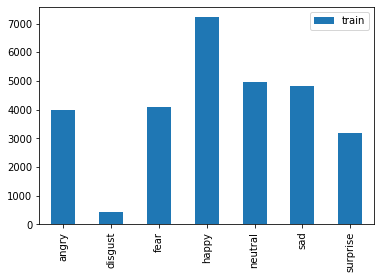

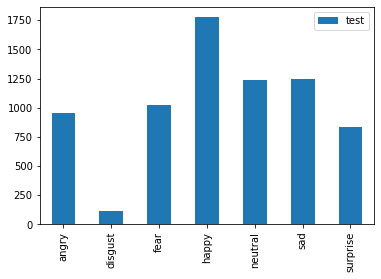

In [11]:
train_count.transpose().plot(kind = 'bar')
test_count.transpose().plot(kind = 'bar')
plt.show()

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                      
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [13]:
train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   shuffle=True,
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  shuffle=True,
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 22968 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# base_model = VGG16(input_shape = (48,48,3), include_top = False, weights = "imagenet")

In [15]:
# for layer in base_model.layers[:-4]:
#     layer.trainable = False

In [16]:
def get_model():
    
    model=  tf.keras.Sequential()
    
    model.add(tf.keras.applications.Xception(input_shape=(71, 71,3),
                                             include_top = False,
                                            weights="imagenet", classes=  7))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(7, activation='softmax'))
    opt = tf.keras.optimizers.Adam(lr=0.0001 , decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
def_model = get_model()
print(def_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 20,875,823
Trainable params: 20,821,295
Non-trainable params: 54,528
_________________________________________________________________
None


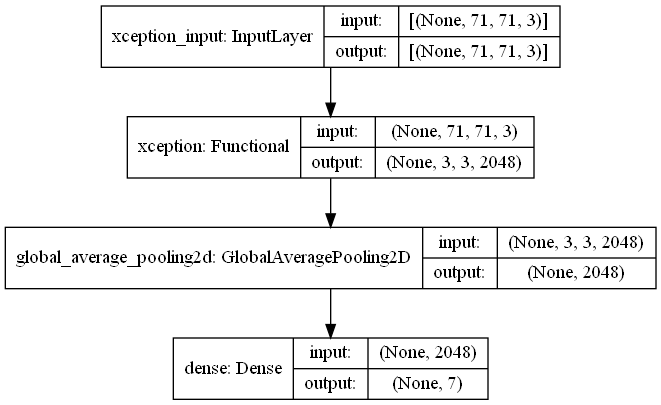

In [18]:
plot_model(def_model, show_shapes=True, show_layer_names=True)

In [19]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model_X.h5')

es = EarlyStopping(verbose=1, patience=20)
callbacks = [lrd,mcp,es]

In [20]:
# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

In [21]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),  
          tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.FalseNegatives(name = "FN"),
           tf.keras.metrics.FalsePositives(name = "FP")]

In [22]:
def_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)
history=def_model.fit(train_dataset,validation_data=test_dataset,epochs = 5,verbose = 1,callbacks= callbacks)

Epoch 1/5
359/359 [==============================] - 2905s 8s/step - loss: 1.9260 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6054 - FN: 11550.1556 - FP: 0.0000e+00 - val_loss: 1.8805 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6406 - val_FN: 7178.0000 - val_FP: 0.0000e+00
Epoch 2/5
359/359 [==============================] - 2384s 7s/step - loss: 1.8712 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6404 - FN: 11551.1111 - FP: 0.0000e+00 - val_loss: 1.8503 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6414 - val_FN: 7178.0000 - val_FP: 0.0000e+00
Epoch 3/5
359/359 [==============================] - 2639s 7s/step - loss: 1.8444 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6420 - FN: 11550.8000 - FP: 0.0000e+00 - val_loss: 1.8354 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.64

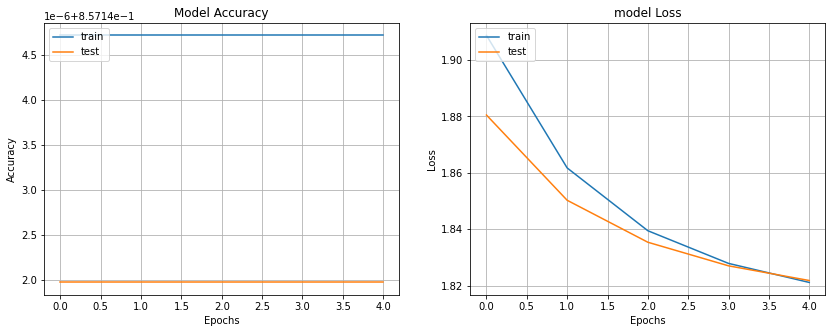

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [25]:
y_pred = def_model.predict(train_dataset)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}
cm_train = confusion_matrix(train_dataset.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_dataset.classes, y_pred, target_names=target_names))

Confusion Matrix
[[   0    0    0 3196    0    0    0]
 [   0    0    0  349    0    0    0]
 [   0    0    0 3278    0    0    0]
 [   0    0    0 5772    0    0    0]
 [   0    0    0 3972    0    0    0]
 [   0    0    0 3864    0    0    0]
 [   0    0    0 2537    0    0    0]]
Classification Report
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      3196
     disgust       0.00      0.00      0.00       349
        fear       0.00      0.00      0.00      3278
       happy       0.25      1.00      0.40      5772
     neutral       0.00      0.00      0.00      3972
         sad       0.00      0.00      0.00      3864
    surprise       0.00      0.00      0.00      2537

    accuracy                           0.25     22968
   macro avg       0.04      0.14      0.06     22968
weighted avg       0.06      0.25      0.10     22968



c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

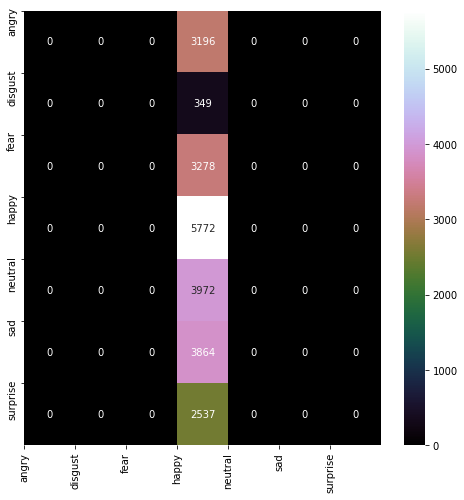

In [26]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_train, annot = True, fmt = "d", cmap=  "cubehelix")
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names,  rotation=90)

In [27]:
y_pred = def_model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_dataset.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_dataset.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))

Confusion Matrix
[[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]
Classification Report
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\adity\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

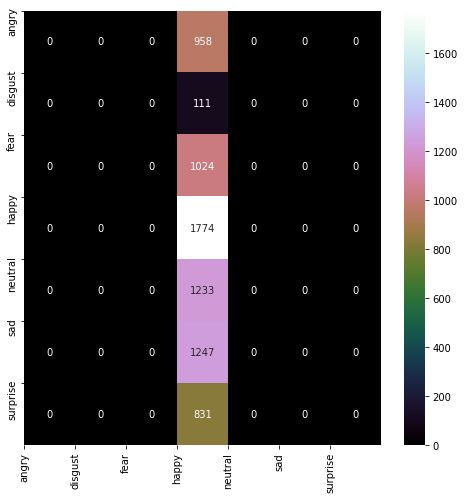

In [28]:
plt.figure(figsize=(8,8))
sns.heatmap(cm_test, annot = True, fmt = "d", cmap=  "cubehelix")
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names,  rotation=90)

In [30]:
model = def_model
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)